In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

import tensorflow as tf
keras = tf.keras

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM

In [2]:
solar_data = pd.read_csv('/kaggle/input/nse-defence-stocks-india/SOLARINDS.NS.csv', index_col='Date')

In [3]:
solar_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-04-03,45.000000,58.000000,44.049999,48.139999,41.433208,71996400
2006-04-10,48.400002,52.459999,46.230000,47.220001,40.641373,8537385
2006-04-17,47.400002,52.189999,47.200001,51.520000,44.342316,4579930
2006-04-24,49.400002,60.799999,48.799999,54.810001,47.173943,10562395
2006-05-01,54.799999,58.000000,51.029999,51.740002,44.531654,1406325


<AxesSubplot:xlabel='Date'>

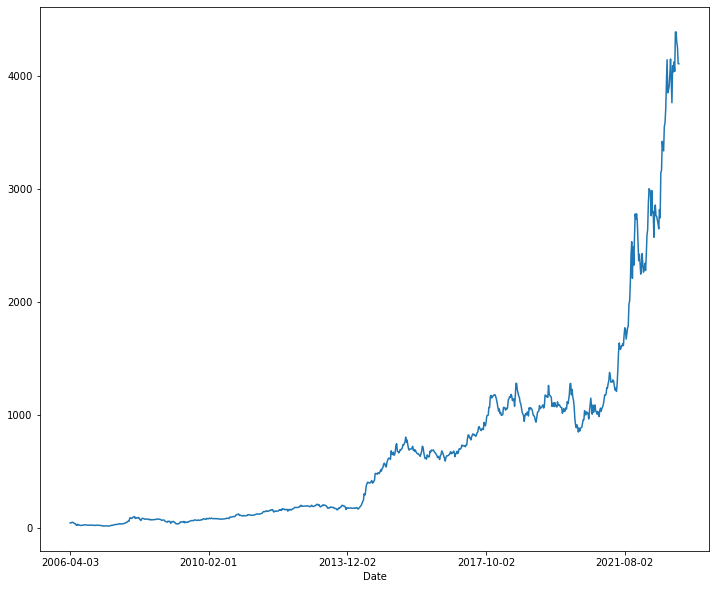

In [4]:
solar_data['Close'].plot(figsize=(12,10))

In [6]:
solar_data = solar_data.dropna()

In [7]:
scaled_solar_data = scaler.fit_transform(solar_data)

In [8]:
scaled_solar_data.shape

(879, 6)

In [9]:
look_back = 6

solar_data_generator = TimeseriesGenerator(scaled_solar_data, scaled_solar_data, length=look_back, batch_size=1)

In [10]:
solar_model = Sequential()

n_features = scaled_solar_data.shape[1]

solar_model.add(LSTM(128, activation='relu', return_sequences=True , input_shape=(look_back,n_features)))
solar_model.add(LSTM(256, activation='relu', return_sequences=True, input_shape=(look_back,n_features)))
solar_model.add(LSTM(512, activation='relu',  input_shape=(look_back,n_features)))

solar_model.add(Dense(n_features))

solar_model.compile(optimizer='adam', loss='mse')

2023-02-04 05:25:40.615511: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [11]:
solar_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 128)            69120     
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 256)            394240    
_________________________________________________________________
lstm_2 (LSTM)                (None, 512)               1574912   
_________________________________________________________________
dense (Dense)                (None, 6)                 3078      
Total params: 2,041,350
Trainable params: 2,041,350
Non-trainable params: 0
_________________________________________________________________


In [12]:
solar_model.fit(solar_data_generator, epochs=500)

2023-02-04 05:26:13.107198: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500
873/873 [==============================] - 29s 28ms/step - loss: 0.0062
Epoch 2/500
873/873 [==============================] - 25s 29ms/step - loss: 0.0019
Epoch 3/500
873/873 [==============================] - 26s 29ms/step - loss: 0.0013
Epoch 4/500
873/873 [==============================] - 25s 28ms/step - loss: 0.0012
Epoch 5/500
873/873 [==============================] - 25s 29ms/step - loss: 0.0011
Epoch 6/500
873/873 [==============================] - 25s 29ms/step - loss: 7.7472e-04
Epoch 7/500
873/873 [==============================] - 24s 28ms/step - loss: 6.8043e-04
Epoch 8/500
873/873 [==============================] - 25s 28ms/step - loss: 8.9041e-04
Epoch 9/500
873/873 [==============================] - 24s 28ms/step - loss: 5.9679e-04
Epoch 10/500
873/873 [==============================] - 24s 28ms/step - loss: 5.4641e-04
Epoch 11/500
873/873 [==============================] - 25s 28ms/step - loss: 4.0956e-04
Epoch 12/500
873/873 [============================

In [13]:
solar_model.save('/kaggle/working/solar_model.h5')

In [14]:
# for exporting important objects of model
import joblib

# create PKL files of important objects required for project
# these are required for prediction of future stock prices and also for the flask app
joblib.dump(scaler, "/kaggle/working/scaler.pkl")
joblib.dump(scaled_solar_data, "/kaggle/working/scaled_solar_data.pkl")
joblib.dump(look_back, "/kaggle/working/look_back.pkl")

['/kaggle/working/look_back.pkl']

<AxesSubplot:>

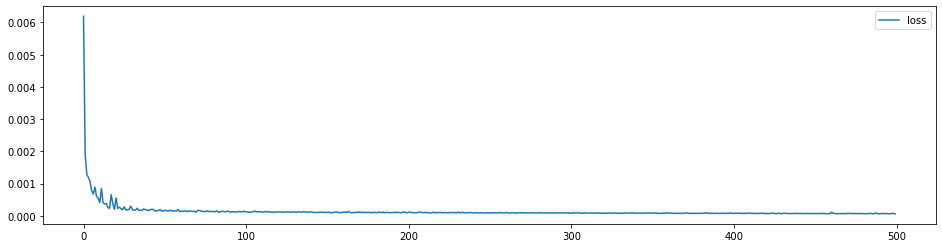

In [15]:
solar_loss = pd.DataFrame(solar_model.history.history)
solar_loss.plot(figsize=(16,4))

In [16]:
# Load the model and the PKL files for prediction
init_solar_model = load_model('solar_model.h5')
init_scaler = joblib.load('/kaggle/working/scaler.pkl')
init_look_back = joblib.load("/kaggle/working/look_back.pkl")
init_scaled_data = joblib.load("/kaggle/working/scaled_solar_data.pkl")

In [17]:
# User inputs how many days into the future they want to predict
# n_days_to_predict = int(input("Enter the number of days you want to predict into the future: "))
n_days_to_predict = 4

In [18]:
# create the predictions
n_features = init_scaled_data.shape[1]

# this array will contain the predictions
forecast = []

# create batches of 31 days worth of data  starting from the last 31 days of the dataset
first_eval_batch = init_scaled_data[-init_look_back:]

# reshape the batch to be fed into the model according to the model's input shape
current_batch = first_eval_batch.reshape((1, init_look_back, n_features))

# loop for predicting the next day's stock price for n_days_to_predict entered above
for i in range(n_days_to_predict):
     # predict the next day's stock price 32nd day's stock price in this case
    current_pred = init_solar_model.predict(current_batch)[0]
    # add the prediction to the forecast array
    forecast.append(current_pred)
    # remove the very last day's data from the end of the batch and append the prediction to the batch
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

In [19]:
forecast

[array([ 0.8925147 ,  0.91404855,  0.88421345,  0.91905093,  0.9185667 ,
        -0.00692866], dtype=float32),
 array([ 0.89172804,  0.91785705,  0.88677096,  0.9258095 ,  0.92547715,
        -0.00678386], dtype=float32),
 array([ 0.90886056,  0.93424934,  0.9043509 ,  0.9378537 ,  0.9374449 ,
        -0.00620934], dtype=float32),
 array([ 0.93287826,  0.9518035 ,  0.922423  ,  0.9472649 ,  0.94715977,
        -0.00684782], dtype=float32)]

In [42]:
# inverse transform into original size
true_forecast = init_scaler.inverse_transform(forecast)
true_forecast

array([[   3972.11853298,    4149.77965908,    3857.2895252 ,
           4032.02646716,    4029.69957566, -497408.93751664],
       [   3968.63565732,    4166.98165606,    3868.39349285,
           4061.53019574,    4059.88436559, -486983.85093141],
       [   4044.48835069,    4241.02137067,    3944.72020174,
           4114.10766664,    4112.15957502, -445621.17116097],
       [   4150.82451871,    4320.30896507,    4023.18396118,
           4155.19119887,    4154.59396703, -491588.4133607 ]])

In [43]:
true_forecast = pd.DataFrame(data=true_forecast, columns=solar_data.columns)

In [44]:
true_forecast

,Open,High,Low,Close,Adj Close,Volume
0,3972.118533,4149.779659,3857.289525,4032.026467,4029.699576,-497408.937517
1,3968.635657,4166.981656,3868.393493,4061.530196,4059.884366,-486983.850931
2,4044.488351,4241.021371,3944.720202,4114.107667,4112.159575,-445621.171161
3,4150.824519,4320.308965,4023.183961,4155.191199,4154.593967,-491588.413361


<AxesSubplot:>

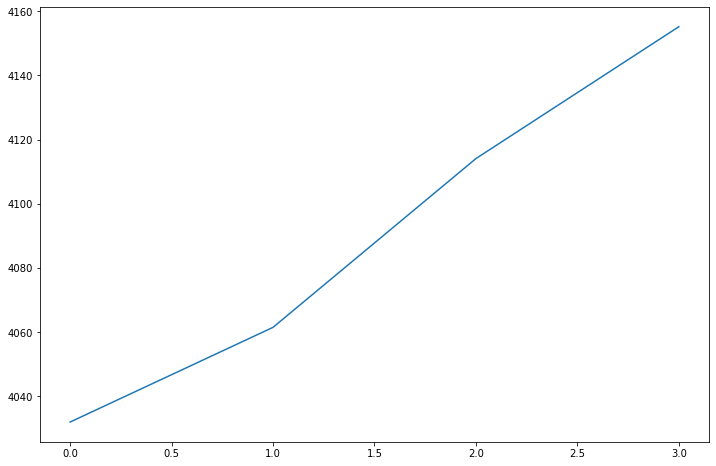

In [45]:
true_forecast['Close'].plot(figsize=(12,8))

In [46]:
last_5_data_of_original = solar_data.tail()

In [47]:
last_5_data_of_original

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-02,4448.000000,4538.000000,4360.000000,4385.399902,4385.399902,380598
2023-01-09,4414.700195,4453.799805,4271.000000,4294.299805,4294.299805,195168
2023-01-16,4323.700195,4381.399902,4222.149902,4249.350098,4249.350098,169713
2023-01-23,4249.500000,4282.549805,3965.000000,4104.200195,4104.200195,264035
2023-01-27,4121.149902,4167.049805,4032.250000,4104.200195,4104.200195,61703


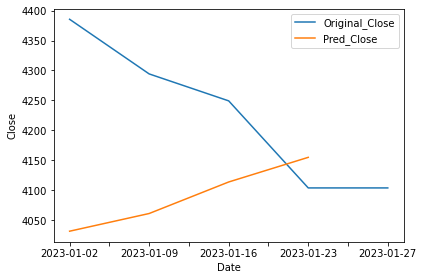

In [52]:
ax = last_5_data_of_original['Close'].plot(label='Original_Close')
true_forecast['Close'].plot(ax=ax, label='Pred_Close')
plt.xlabel('Date')
plt.ylabel('Close')
plt.tight_layout()
plt.legend()
plt.show()